In [1]:
%matplotlib inline

<a id='toc'></a>
### Notebook Table of Contents
[Imports](#imports) <br>
[Original Image:](#original) <br>
[Code:](#code) <br>
[Second Difference:](#seconddiffs) <br>
****
# Quaternions as data-type, 3D Gradient operations
Free Unified Rendering in Python [pypi FURY](https://pypi.org/project/fury/), [](), [](), []() <br>
[Brain Extraction Tool](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET) <br>
Robust Brain Extraction [ROBEX](https://www.nitrc.org/projects/robex) <br>
****
Berkeley Psyc 214 fall 2016 [dipy](https://bic-berkeley.github.io/psych-214-fall-2016/dipy_registration.html) <br>
dipy: [tutorials](https://dipy.org/tutorials/), [](), [](), []() <br>
[Open Neuro](https://openneuro.org/) <br>
[Oxford FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki) <br>
****
****
[TorchIO dakine](https://torchio.readthedocs.io/index.html) <br>

~~~text
        HAL seek: ADNI 3 dataset
~~~

****
[Table of Contents (page top)](#toc) <br>
### Import 
#### modules, packages, whatever, ...

In [2]:
import numpy as np

phase = np.linspace(0, np.pi, num=5)
phase[3:] += np.pi
phase
# array([ 0.        ,  0.78539816,  1.57079633,  5.49778714,  6.28318531]) # may vary

np.unwrap(phase)
# array([ 0.        ,  0.78539816,  1.57079633, -0.78539816,  0.        ]) # may vary

np.unwrap([0, 1, 2, -1, 0], period=4)
# array([0, 1, 2, 3, 4])

np.unwrap([ 1, 2, 3, 4, 5, 6, 1, 2, 3], period=6)
# array([1, 2, 3, 4, 5, 6, 7, 8, 9])

np.unwrap([2, 3, 4, 5, 2, 3, 4, 5], period=4)
# array([2, 3, 4, 5, 6, 7, 8, 9])


phase_deg = np.mod(np.linspace(0 ,720, 19), 360) - 180
np.unwrap(phase_deg, period=360)

array([-180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
        180.,  220.,  260.,  300.,  340.,  380.,  420.,  460.,  500.,
        540.])

In [3]:
import numpy as np

phase = np.linspace(0, np.pi, num=5)
phase[3:] += np.pi
phase
# array([ 0.        ,  0.78539816,  1.57079633,  5.49778714,  6.28318531]) # may vary

array([0.        , 0.78539816, 1.57079633, 5.49778714, 6.28318531])

In [4]:
np.unwrap(phase)
# array([ 0.        ,  0.78539816,  1.57079633, -0.78539816,  0.        ]) # may vary

array([ 0.        ,  0.78539816,  1.57079633, -0.78539816,  0.        ])

In [5]:
np.unwrap([0, 1, 2, -1, 0], discont=4)
# array([0, 1, 2, 3, 4])

array([ 0.,  1.,  2., -1.,  0.])

In [6]:
np.unwrap([ 1, 2, 3, 4, 5, 6, 1, 2, 3], period=6)
# array([1, 2, 3, 4, 5, 6, 7, 8, 9])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
np.unwrap([2, 3, 4, 5, 2, 3, 4, 5], period=4)
# array([2, 3, 4, 5, 6, 7, 8, 9])

array([2, 3, 4, 5, 6, 7, 8, 9])

In [8]:

phase_deg = np.mod(np.linspace(0 ,720, 19), 360) - 180
np.unwrap(phase_deg, period=360)

array([-180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
        180.,  220.,  260.,  300.,  340.,  380.,  420.,  460.,  500.,
        540.])

In [9]:
#                                            else nibabel writes in red
import warnings
warnings.filterwarnings('ignore')

#                                            demo examination tools
import time, os, sys
from collections import defaultdict

import numpy as np
import quaternion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import pydicom
import nibabel as nib
import ipyvolume as ipv

#                                            basic transform demo imports
from dipy.viz import regtools
from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

#                                            Non-Linear transform demo imports
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

nb_after_import_start_time = time.time()

In [10]:
adni_dir = os.path.abspath('../../../../DATA/Kiaran_ADNI')
os.listdir(adni_dir)

['ANDI 3 MR - Flobetapir search Oct 2021_002.xlsx',
 '.DS_Store',
 'MR and 18F PET - Jan 27 2022.xlsx',
 'ADNI3_PET_AV45.xlsx',
 'ANDI 3 MR - Flobetapir search Oct 2021.xlsx',
 'ADNI',
 'Meta_ADNI3_3T_3D_AV45']

In [11]:
t_start = time.time()
file_types = ['.nii', '.dcm']
adni_image_files_dict = {}
nifti_files = []
dicom_files = []

for d, dl, fl in os.walk(adni_dir):
    for f in fl:
        f_ext = os.path.splitext(f)[1]
        if f_ext in file_types:
            full_file = os.path.join(d, f)
            if f in adni_image_files_dict:
                print('Fooey: duplicates', os.path.join(d, f))
            adni_image_files_dict[f] = full_file
            if f_ext == '.nii':
                nifti_files.append(full_file)
            elif f_ext == '.dcm':
                dicom_files.append(full_file)
                
tt = time.time() - t_start

print('found:\n%03i dicom\n%03i nifti\n %i total files %0.6f'%(len(dicom_files), 
                                                               len(nifti_files), 
                                                               len(adni_image_files_dict),
                                                               tt))

found:
1094596 dicom
9522 nifti
 1104118 total files 9.314695


****
<a id='original'></a>
[Table of Contents (page top)](#toc) <br>
[Code](#code) <br>
[Second Difference:](#seconddiffs) <br>


#### Image file select

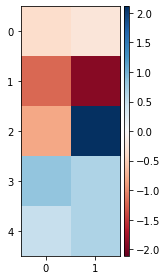

In [26]:
from skimage import io
import numpy as np
data=np.random.randn(5,2)
io.imshow(data)

In [12]:
goodies = [0, 4]
for i in range(40):
    full_file = nifti_files[i]
    # im_data = pydicom.dcmread(full_file).pixel_array
    nifty_image = nib.load(full_file)
    nifty_image_disp = nifty_image.get_data()
    print(i, type(nifty_image_disp), nifty_image_disp.shape, 
          type(nifty_image_disp[0,0,0]), nifty_image_disp[0,0,0])
    
# pick one here:
full_file = nifti_files[0]
nifty_image = nib.load(full_file)
nifty_image_disp = nifty_image.get_data()

0 <class 'numpy.memmap'> (160, 256, 256) <class 'numpy.int16'> 0
1 <class 'numpy.memmap'> (182, 256, 256) <class 'numpy.int16'> 0
2 <class 'numpy.memmap'> (64, 64, 64, 2) <class 'numpy.memmap'> [8 7]
3 <class 'numpy.memmap'> (162, 162, 1) <class 'numpy.int16'> 0
4 <class 'numpy.memmap'> (208, 240, 256) <class 'numpy.int16'> 0
5 <class 'numpy.memmap'> (128, 128, 46) <class 'numpy.float32'> 0.0
6 <class 'numpy.memmap'> (160, 256, 256) <class 'numpy.int16'> 0
7 <class 'numpy.ndarray'> (80, 80, 52) <class 'numpy.float64'> -3.141592502593994
8 <class 'numpy.memmap'> (160, 256, 256) <class 'numpy.int16'> 0
9 <class 'numpy.memmap'> (162, 162, 1) <class 'numpy.int16'> 0
10 <class 'numpy.memmap'> (64, 64, 64, 2) <class 'numpy.memmap'> [4 6]
11 <class 'numpy.memmap'> (128, 128, 32, 20) <class 'numpy.memmap'> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
12 <class 'numpy.ndarray'> (96, 96, 40) <class 'numpy.float64'> 0.0
13 <class 'numpy.memmap'> (162, 162, 1) <class 'numpy.int16'> 0
14 <class 'numpy

In [13]:
print('selected file: %s\nOpened as type %s size:'%(full_file, type(nifty_image_disp)), nifty_image_disp.shape)

selected file: /Users/daniellanier/DATA/Kiaran_ADNI/ADNI/_Sagittal_3D_FLAIR_20210621104220_3.nii
Opened as type <class 'numpy.memmap'> size: (160, 256, 256)


<a id='code'></a>
[Table of Contents (page top)](#toc) <br>
[Original Image:](#original) <br>

#### Code

In [14]:
def get_quat_zeros(arr_size):
    return np.ones(arr_size) * np.quaternion(1,0,0,0)

def get_quat_ones(arr_size):
    return np.ones(arr_size) * np.quaternion(1,1,1,1)

Q_ID_dict = {'w': np.quaternion(1,0,0,0), 
             'i': np.quaternion(0,1,0,0), 
             'j': np.quaternion(0,0,1,0), 
             'k': np.quaternion(0,0,0,1)}

def voxels_quaternion_slice_doublets_dict(n_x, n_y, n_z):
    # width of central difference in voxels:
    qdd = 13                              # 13 quaternions - magnitude divisor
    half_shift = 1                        # 1/2 central difference accross voxel
    n_shift = half_shift * 2              # indexing central difference for any direction

    #     n_x, n_y, n_z = im_arr.shape
    #     im_grad_arr = get_quat_ones(im_arr.shape)
    im_grad_arr = get_quat_ones((n_x, n_y, n_z))

    mid_x = slice(half_shift, n_x - half_shift)
    mid_y = slice(half_shift, n_y - half_shift)
    mid_z = slice(half_shift, n_z - half_shift)
    mddl = (mid_x, mid_y, mid_z)

    print('(padded) output shape:', im_grad_arr.shape, '\ngradient (middle) shape:', im_grad_arr[mddl].shape)
    """
                for i in q_ix:
                    G += (b_i - a_i) * q_i    

    iterate: each quaternion direction with slices: I[b_slice[x], b_slice[y], b_slice[z]] - I[a_slize[x]...]
    """

    #                                       Vector ~ Slice-a, Slice-b
    #                                       on-axis: x, x & y
    qx = Q_ID_dict['i']
    qx_a = (slice(0, n_x - n_shift), mid_y, mid_z)
    qx_b = (slice(n_shift, n_x), mid_y, mid_z)

    qy = Q_ID_dict['j']
    qy_a = (mid_x, slice(0, n_y - n_shift), mid_z)
    qy_b = (mid_x, slice(n_shift, n_y), mid_z)

    qz = Q_ID_dict['k']
    qz_a = (mid_x, mid_y, slice(0, n_z - n_shift))
    qz_b = (mid_x, mid_y, slice(n_shift, n_z))


    #                                       in-plane: x+y, x-y, y+z, y-z, z+y
    qxy = qx + qy
    qxy_a = (slice(0, n_x - n_shift), slice(0, n_y - n_shift), mid_z)
    qxy_b = (slice(n_shift, n_x), slice(n_shift, n_y), mid_z)

    qx_y = qx - qy
    qx_y_a = (slice(0, n_x - n_shift), slice(n_shift, n_y), mid_z)
    qx_y_b = (slice(n_shift, n_x), slice(0, n_y - n_shift), mid_z)

    qyz = qy + qz
    qyz_a = (mid_x, slice(0, n_y - n_shift), slice(0, n_z - n_shift))
    qyz_b = (mid_x, slice(n_shift, n_y), slice(n_shift, n_z))

    qy_z = qy - qz
    qy_z_a = (mid_x, slice(0, n_y - n_shift), slice(n_shift, n_z))
    qy_z_b = (mid_x, slice(n_shift, n_y), slice(0, n_z - n_shift))

    qzx = qz + qx
    qzx_a = (slice(0, n_x - n_shift), mid_y, slice(0, n_z - n_shift))
    qzx_b = (slice(n_shift, n_x), mid_y, slice(n_shift, n_z))

    qz_x = qz - qx
    qx_z_a = (slice(n_shift, n_x), mid_y, slice(0, n_z - n_shift))
    qx_z_b = (slice(0, n_x - n_shift), mid_y, slice(n_shift, n_z))


    # x, y, z Totally positive
    qxyz = qx + qy + qz
    qxyz_a = (slice(0, n_x - n_shift), slice(0, n_y - n_shift), slice(0, n_z - n_shift))
    qxyz_b = (slice(n_shift, n_x), slice(n_shift, n_y), slice(n_shift, n_z))

    # -x, y, z
    q_xyz = qy + qz - qx
    q_xyz_a = (slice(n_shift, n_x), slice(0, n_y - n_shift), slice(0, n_z - n_shift))
    q_xyz_b = (slice(0, n_x - n_shift), slice(n_shift, n_y), slice(n_shift, n_z))

    # x, -y, z
    qx_yz = qx - qy + qz
    qx_yz_a = (slice(0, n_x - n_shift), slice(n_shift, n_y), slice(0, n_z - n_shift))
    qx_yz_b = (slice(n_shift, n_x), slice(0, n_y - n_shift), slice(n_shift, n_z))

    # x, y, -z
    qxy_z = qx + qy - qz
    qxy_z_a = (slice(0, n_x - n_shift), slice(0, n_y - n_shift), slice(n_shift, n_z))
    qxy_z_b = (slice(n_shift, n_x), slice(n_shift, n_y), slice(0, n_z - n_shift))


    vox_pd_vex = {'qx': {'q': qx / qdd, 'a': qx_a, 'b': qx_b}, 
                  'qy': {'q': qy / qdd, 'a': qy_a, 'b': qy_b}, 
                  'qz': {'q': qz / qdd, 'a': qz_a, 'b': qz_b},  
                  'qxy': {'q': qxy / qdd, 'a': qxy_a, 'b': qxy_b}, 
                  'qx_y': {'q': qx_y / qdd, 'a': qx_y_a, 'b': qx_y_b}, 
                  'qyz': {'q': qyz / qdd, 'a': qyz_a, 'b': qyz_b}, 
                  'qy_z': {'q': qy_z / qdd, 'a': qy_z_a, 'b': qy_z_b}, 
                  'qzx': {'q': qzx / qdd, 'a': qzx_a, 'b': qzx_b},  
                  'qz_x': {'q': qz_x / qdd, 'a': qx_z_a, 'b': qx_z_b}, 
                  'qxyz': {'q': qxyz / qdd, 'a': qxyz_a, 'b': qxyz_b}, 
                  'q_xyz': {'q': q_xyz / qdd, 'a': q_xyz_a, 'b': q_xyz_b}, 
                  'qx_yz': {'q': qx_yz / qdd, 'a': qx_yz_a, 'b': qx_yz_b},
                  'qxy_z': {'q': qxy_z / qdd, 'a': qxy_z_a, 'b': qxy_z_b} }
    
    return vox_pd_vex

In [15]:
def get_quat_grad_middle_w_slices_list(arr3D):
    """middle_slice, slices_list = get_quat_grad_middle_w_slices_list(arr3D)
    """
    slices_list = []
    n_x, n_y, n_z = arr3D.shape
    
    # name the numbers
    half_shift = 1
    full_shift = 2

    zro_x = slice(0, n_x - full_shift)
    zro_y = slice(0, n_y - full_shift)
    zro_z = slice(0, n_z - full_shift)
    
    mid_x = slice(half_shift, n_x - half_shift)
    mid_y = slice(half_shift, n_y - half_shift)
    mid_z = slice(half_shift, n_z - half_shift)
    
    end_x = slice(full_shift, n_x)
    end_y = slice(full_shift, n_y)
    end_z = slice(full_shift, n_z)
    
    middle_slice = (mid_x, mid_y, mid_z)
    
    for x in [zro_x, mid_x, end_x]:
        for y in [zro_y, mid_y, end_y]:
            for z in [zro_z, mid_z, end_z]:
                temporary_slice = (x,y,z)
                if middle_slice == temporary_slice:
                    pass
                else:
                    slices_list.append(temporary_slice)
    
    return middle_slice, slices_list

    

In [16]:
def get_quaternion_gradient_II(arr3D):
    """quat_grad = get_quaternion_gradient_II(arr3D)
    """
    # allocate padded 3d array
    quat_diffs = get_quat_zeros(arr3D.shape)
    middle_slice, slices_list = get_quat_grad_middle_w_slices_list(arr3D)
    arr3D_middle = arr3D[middle_slice]
    
    for shifter_slice in slices_list:
        quat_diffs[middle_slice] += arr3D_middle - arr3D[shifter_slice]
        
    return quat_diffs

def get_quaternion_gradient(quat_arr):
    """ grad_arr = get_quaternion_gradient(quat_arr) """
    # allocate the return array - same shape as input (padded w q zeros)
    grad_arr = get_quat_zeros(quat_arr.shape)
    
    # name the numbers
    half_shift = 1
    n_x, n_y, n_z = quat_arr.shape
    
    mid_x = slice(half_shift, n_x - half_shift)
    mid_y = slice(half_shift, n_y - half_shift)
    mid_z = slice(half_shift, n_z - half_shift)
    mddl = (mid_x, mid_y, mid_z)
    
    # get the quaternion slices dictionary
    for q_name, v in voxels_quaternion_slice_doublets_dict(n_x, n_y, n_z).items():
        grad_arr[mddl] += (quat_arr[v['b']] - quat_arr[v['a']])
    
    return grad_arr


def gradient3D(im3_arr):
    
    # allocate the return array - same shape as input (padded w q zeros)
    out_arr = get_quat_zeros(im3_arr.shape)
    
    # name the numbers
    half_shift = 1
    n_x, n_y, n_z = im3_arr.shape
    
    mid_x = slice(half_shift, n_x - half_shift)
    mid_y = slice(half_shift, n_y - half_shift)
    mid_z = slice(half_shift, n_z - half_shift)
    mddl = (mid_x, mid_y, mid_z)
    
    # get the quaternion slices dictionary
    for q_name, v in voxels_quaternion_slice_doublets_dict(n_x, n_y, n_z).items():
        out_arr[mddl] += (im3_arr[v['b']] - im3_arr[v['a']]) * v['q']
    
    return out_arr

t0 = time.time()
gra_im = gradient3D(nifty_image_disp)

nifty_image_disp.shape, gra_im.shape, print('%0.6f'%(time.time()-t0))

(padded) output shape: (160, 256, 256) 
gradient (middle) shape: (158, 254, 254)
1.730228


((160, 256, 256), (160, 256, 256), None)

In [17]:
def im_norm(im_in):
    im_in = im_in - im_in.min()
    im_in = im_in / im_in.max()
    return im_in

def flat_index(float_mat):
    """ convert the input matrix to integers from 0 to number of unique values.
    
    Args:
        float_mat: two dimensional matrix.
        
    Return:
        float_mat: re-enumerated so that the matrix values are all sequential ints.
        n_colors:  number of unique values in the input / output matrix
    """
    float_mat_shape = float_mat.shape
    
    float_mat = np.reshape(float_mat, (1, float_mat.size))
    ixA = np.argsort(float_mat)[0]
    
    current_value = float_mat[0, ixA[0]]
    
    enumeration_value = 0
    for ix in ixA:
        if float_mat[0,ix] != current_value:
            current_value = float_mat[0,ix]
            enumeration_value += 1
        float_mat[0,ix] = enumeration_value

    float_mat = np.array(np.reshape(float_mat, float_mat_shape))

    float_mat = np.int_(float_mat)

    return float_mat

f_mat  = flat_index(nifty_image_disp)
type(f_mat), type(f_mat[0]), f_mat.shape, f_mat.max(), f_mat.min()

(numpy.ndarray, numpy.ndarray, (160, 256, 256), 768, 0)

<a id='original'></a>
[Table of Contents (page top)](#toc) <br>
[Code](#code) <br>
[Second Difference:](#seconddiffs) <br>


#### Display: Original "Input Image"

In [18]:
nifty_image_normalized = im_norm(nifty_image_disp)
nifty_image_disp.shape, nifty_image_normalized.shape

ipv.figure()
ipv.volshow(nifty_image_normalized, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()


#### display Original as ranked values:

In [19]:
nifty_image_ranked_disp = flat_index(nifty_image_disp)
nifty_image_ranked_disp = im_norm(nifty_image_ranked_disp)

ipv.figure()
ipv.volshow(nifty_image_ranked_disp, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()

#### Display Gradient Image

In [20]:
# gra_im = gradient3D(nifty_image_disp) # as called above
# Normalize as image
grd_mag_im = np.abs(gra_im)
grd_mag_im = im_norm(grd_mag_im)

# display as point cloud
ipv.figure()
ipv.volshow(grd_mag_im, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()

In [21]:
for t in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1, 0.0]:
    print(' >= %0.2f %12i %12i'%(t, np.sum(grd_mag_im >= t), np.sum(grd_mag_im < t)))


 >= 0.90           34     10485726
 >= 0.80          207     10485553
 >= 0.70          708     10485052
 >= 0.60         1530     10484230
 >= 0.50         2513     10483247
 >= 0.40         4097     10481663
 >= 0.30         7348     10478412
 >= 0.20        16108     10469652
 >= 0.10       169471     10316289
 >= 0.00     10485760            0


#### Bone of Contention: 26 neighborhood 1st difference stats as selector in context of whole image visibility

In [22]:
t0 = time.time()
quat_grad = get_quaternion_gradient_II(gra_im)

tt = time.time() - t0
print('%0.3f'%(tt))

3.182


In [23]:
grdII_mag_im = np.abs(quat_grad)
grdII_mag_im = im_norm(grdII_mag_im)
# grdII_mag_im = grdII_mag_im - grdII_mag_im.min()
# grdII_mag_im = grdII_mag_im / grdII_mag_im.max()

# display as point cloud
ipv.figure()
ipv.volshow(grdII_mag_im, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()

Berkely Psyc 214: [making and saving new images](https://bic-berkeley.github.io/psych-214-fall-2016/saving_images.html) with nibabel <br>

In [24]:
t0 = time.time()
grad_arr = get_quaternion_gradient(gra_im)
print('%0.3f'%(time.time() - t0))

(padded) output shape: (160, 256, 256) 
gradient (middle) shape: (158, 254, 254)
1.771


<a id='seconddiffs'></a>
[Table of Contents (page top)](#toc) <br>
[Original Image:](#original) <br>
[Code:](#code) <br>

#### Second differences

In [25]:
# Normalize as image quat_grad
# grdII_mag_im = np.abs(grad_arr)
grdII_mag_im_old = np.abs(grad_arr)
grdII_mag_im_old = im_norm(grdII_mag_im_old)

# display as point cloud
ipv.figure()
ipv.volshow(grdII_mag_im_old, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(-30, 40)
ipv.show()

##### pasted at breaktime:
### details for nibabel saving

~~~python
# import os, time
# import nibabel as nib

#                                        Name & write
transformed_img = nib.Nifti1Image(transformed, template_img.affine, template_img.header)
template_img = nib.Nifti1Image(template_data, template_affine, template_img.header)

nib.save(transformed_img, os.path.join(data_dir, 'XXX_transformed_NB1.nii'))
nib.save(template_img, os.path.join(data_dir, 'XXX_template_NB1.nii'))

tt = time.time() - nb_after_import_start_time
print(f'{tt:0.3f} total run time')
~~~

### Thank you, Berkley Psyc 214
~~~python
import time, os

import numpy as np
import nibabel as nib

from dipy.viz import regtools
from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

# nb_after_import_start_time = time.time()

# #                                            file names full path
# data_dir = os.path.abspath('../../../../DATA/ADNI_test')

# mri_file = 'ADNI_002_S_1155_MR_Accelerated_Sagittal_MPRAGE__br_raw_20170425131856689_29_S558282_I843510.nii'
# mri_file = os.path.join(data_dir, mri_file)

# pet_file = 'ADNI_002_S_1155_PT_ADNI_Brain_PET__Raw_br_raw_20170421115500090_163_S556709_I841767.nii'
# pet_file = os.path.join(data_dir, pet_file)

# moving_img = nib.load(mri_file)
# template_img = nib.load(pet_file)

# moving_data = moving_img.get_fdata()
# moving_affine = moving_img.affine

# template_data = template_img.get_fdata()
# template_affine = template_img.affine

# identity = np.eye(4)
# affine_map = AffineMap(identity, template_data.shape, template_affine, moving_data.shape, moving_affine)
# resampled = affine_map.transform(moving_data)

# # The mismatch metric
# nbins = 32
# sampling_prop = None
# metric = MutualInformationMetric(nbins, sampling_prop)

# # The optimization strategy
# level_iters = [10, 10, 5]    # level_iters = [100, 100, 50] # 43 seconds vs 
# sigmas = [3.0, 1.0, 0.0]
# factors = [4, 2, 1]

# affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)

# transform = TranslationTransform3D()
# params0 = None
# translation = affreg.optimize(template_data, moving_data, transform, params0, template_affine, moving_affine)

# transformed = translation.transform(moving_data)

# transform = RigidTransform3D()
# rigid = affreg.optimize(template_data, moving_data, transform, params0, template_affine, 
#                         moving_affine, starting_affine=translation.affine)

# transformed = rigid.transform(moving_data)

# transform = AffineTransform3D()

# # Bump up the iterations to get an more exact fit
# affreg.level_iters = [1000, 1000, 100]    # [2000, 2000, 200] # 43 sec vs dkine above

# affine = affreg.optimize(template_data, moving_data, transform, params0, template_affine, 
#                          moving_affine, starting_affine=rigid.affine)

# transformed = affine.transform(moving_data)


#                                        Name & write
transformed_img = nib.Nifti1Image(transformed, template_img.affine, template_img.header)
template_img = nib.Nifti1Image(template_data, template_affine, template_img.header)

nib.save(transformed_img, os.path.join(data_dir, 'XXX_transformed_NB1.nii'))
nib.save(template_img, os.path.join(data_dir, 'XXX_template_NB1.nii'))

tt = time.time() - nb_after_import_start_time
print(f'{tt:0.3f} total run time')
~~~